# Used Car Price Prediction


## Objective

The objective of this competition is to **predict the price of used cars** based on various attributes, such as brand, model, manufacturing year, mileage, <br>
fuel type, engine specifications, and more. Participants are required to build a machine learning model that accurately estimates car prices using the <br>
provided dataset, which contains information about each vehicle's features and characteristics. The model's performance will be evaluated based on <br>
the **Root Mean Squared Error (RMSE)** between the predicted prices and the actual prices.

## Dataset

- **Brand & Model**: Identify the brand or company name along with the specific model of each vehicle.
- **Model Year**: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.
- **Mileage**: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.
- **Fuel Type**: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.
- **Engine Type**: Understand the engine specifications, shedding light on performance and efficiency.
- **Transmission**: Determine the transmission type, whether automatic, manual, or another variant.
- **Exterior & Interior Colors**: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.
- **Accident History**: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.
- **Clean Title**: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.
- **Price**: Access the listed prices for each vehicle, aiding in price comparison and budgeting.

## Initial Data Exploration

### What the data looks like

In [83]:
# Load necessary libraries
import pandas as pd
import numpy as np
import warnings
import re
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


warnings.filterwarnings("ignore")

In [84]:
# Load the dataset
train_df = pd.read_csv('/Users/shudizhao/data_projects/used_car_price_prediction/train.csv')
test_df = pd.read_csv('/Users/shudizhao/data_projects/used_car_price_prediction/test.csv')

# # Randomly split the data, keeping 10% for the holdout set
# train_df, holdout_df = train_test_split(train_df, test_size=0.1, random_state=42)

# # Check the sizes of the datasets
# print(f"Training data size: {train_df.shape}")
# print(f"Holdout data size: {holdout_df.shape}")

# Preview the data
print("Train Data:")
train_df.head()

Train Data:


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [85]:
print("\nTest Data:")
test_df.head()


Test Data:


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [86]:
# Check the structure and data types
print("\nTrain Data Info:")
train_df.info()
print()
print('='*50)
print()
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB



Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
--

### What are the values we have for each columns

* Values Counts for each Categorical Columns
* Distribution for Numerical Columns
* Percentage of missing values in each column

Traning Data

In [87]:
# List of categorical features
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

# Value counts for each categorical feature
for feature in categorical_features:
    print(f"\nValue counts for {feature}:")
    print(train_df[feature].value_counts())
    
numerical_features = ['milage', 'price']

# Descriptive statistics for numerical features
print("\nDescriptive statistics for numerical features:")
print(train_df[numerical_features].describe().round(2))


Value counts for brand:
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Ast

In [88]:
def calculate_missing_percentage(train_df): 
    # Calculate the percentage of missing values
    missing_values_percentage = ((train_df.isnull().sum() / len(train_df)) * 100).round(2)

    # Get data types of each column
    data_types = train_df.dtypes

    # Combine the missing values and data types into a DataFrame for easier viewing
    missing_and_dtypes = pd.DataFrame({
        'Missing Percentage': missing_values_percentage,
        'Data Type': data_types
    })

    print("\nMissing Percentage and Data Types for Each Column:")
    print(missing_and_dtypes)
calculate_missing_percentage(train_df)


Missing Percentage and Data Types for Each Column:
              Missing Percentage Data Type
id                          0.00     int64
brand                       0.00    object
model                       0.00    object
model_year                  0.00     int64
milage                      0.00     int64
fuel_type                   2.70    object
engine                      0.00    object
transmission                0.00    object
ext_col                     0.00    object
int_col                     0.00    object
accident                    1.30    object
clean_title                11.36    object
price                       0.00     int64


In [89]:
# Check categorical feature cardinality
train_df.nunique()

id              188533
brand               57
model             1897
model_year          34
milage            6651
fuel_type            7
engine            1117
transmission        52
ext_col            319
int_col            156
accident             2
clean_title          1
price             1569
dtype: int64

Test Data 

In [90]:
# List of categorical features
categorical_features = ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

# Value counts for each categorical feature
for feature in categorical_features:
    print(f"\nValue counts for {feature}:")
    print(test_df[feature].value_counts())
    
numerical_features = ['milage']

# Descriptive statistics for numerical features
print("\nDescriptive statistics for numerical features:")
print(test_df[numerical_features].describe().round(2))


Value counts for brand:
brand
Ford             15265
Mercedes-Benz    12875
BMW              11286
Chevrolet        10698
Audi              7289
Porsche           7153
Land              6348
Toyota            6084
Lexus             5729
Jeep              4412
Cadillac          3059
RAM               2753
Nissan            2674
Tesla             2387
INFINITI          2123
GMC               2094
Dodge             2071
Mazda             1770
Kia               1750
Lincoln           1593
Subaru            1591
Acura             1567
Honda             1436
Hyundai           1308
Volkswagen        1222
Jaguar             934
Bentley            789
MINI               697
Buick              651
Genesis            643
Maserati           619
Volvo              576
Lamborghini        547
Chrysler           514
Alfa               467
Rivian             390
Rolls-Royce        383
Mitsubishi         367
Hummer             342
Pontiac            341
Ferrari            251
McLaren            165
Ast

In [91]:
calculate_missing_percentage(test_df)


Missing Percentage and Data Types for Each Column:
              Missing Percentage Data Type
id                          0.00     int64
brand                       0.00    object
model                       0.00    object
model_year                  0.00     int64
milage                      0.00     int64
fuel_type                   2.69    object
engine                      0.00    object
transmission                0.00    object
ext_col                     0.00    object
int_col                     0.00    object
accident                    1.30    object
clean_title                11.33    object


In [92]:
# Check categorical feature cardinality
test_df.nunique()

id              125690
brand               55
model             1891
model_year          36
milage            5700
fuel_type            7
engine            1117
transmission        52
ext_col            317
int_col            156
accident             2
clean_title          1
dtype: int64

### Quick Summary 

1. clean_title with 11.36% missing values, and no False value. (how to impute? Since we are not sure of null means False, Let's consider it as "Unknown")
2. accident has 1.3% missing values, and fuel_type has 2.7% missing values(Mode imputation is a good option when the missing percentage is low, and the column is likely to follow a common distribution.)
3. Many columns has value "–", let's convert it to Null and fill with Mode as well.
4. Low-cardinality categorical features: fuel_type(7), transmission(52 unique values, but included as low due to its categorical nature), accident(2), clean_title(True, Unknown)
5. High-cardinality categorial features: brand(57), model(1897), model_year(34), engine(1117), ext_col(319), int_col(156)
6. milage is a numerical value and only has 6651 unique values that means we can make it categorical feature then apply categorical encodings.

### Next Actions

1. **Fill missing values**
2. **Replace "–" with mode**
3. **Categorize Numerical Feature**<br><br>
    **milage**:<br>
    
    Since milage is a critical factor in vehicle pricing and it’s important to create bins that make sense in the real world, custom binning based on domain knowledge is likely the better choice here. You can create mileage categories that align with how the automotive industry views mileage.
    
    Based on common mileage groupings in the automotive industry:

	1.	Low Mileage: 0 - 30,000 miles
	•	Typically considered a “newer” car with lower wear and tear.
	2.	Medium Mileage: 30,000 - 70,000 miles
	•	Often considered average mileage.
	3.	High Mileage: 70,000 - 150,000 miles
	•	Starting to show signs of wear but still within a typical range for used cars.
	4.	Very High Mileage: 150,000+ miles
	•	Usually older or heavily used cars, likely to require more maintenance.

3. **Feature Engineering**

    1. **Feature Grouping or Aggregation**: If multiple features convey similar or related information, you can group them into broader categories or combine them using domain knowledge.
    2. **Clustering Similar Categories**: If features like brand, model, or engine have many unique values but some categories are similar, you can reduce the number of unique categories by clustering similar ones together.
    3. **Feature Interactions and Combinations**: Instead of using similar features individually, you can combine them to create interaction terms or new features that capture the combined effect.
    4. **Text Feature Grouping**: For high-cardinality text features like model, you can use techniques like NLP to group similar models based on the text of the feature names. For instance, models with similar prefixes or suffixes (F-150, F-150 XLT, F-150 Lariat) can be grouped together.
    5. When all features a properly preprocessed, we can apply One-Hot Encoding or Label Encoding on Low-cardinality categorical features and apply Target Encoding, Frequency Encoding or Binary Encoding on High-cardinality categorical features
    6. Correlation Analysis and Feature Selection
    7. Principal Component Analysis(PCA) for dimension reduction 



## Feature Engineering

* Wrap up it into a function so we can simply apply to the test data

In [93]:
# Load the dataset
train_df = pd.read_csv('/Users/shudizhao/data_projects/used_car_price_prediction/train.csv')
test_df = pd.read_csv('/Users/shudizhao/data_projects/used_car_price_prediction/test.csv')

### Missing Value Handeling

In [94]:
############################
# Missing Value Handeling #
##########################

# Count the number of rows with "–" in each column
dash_counts = (train_df == '–').sum()

# Display the count for each column
print("Number of rows with '–' for each column(need to treat it later):")
print(dash_counts)

# Step 1: Fill missing values in 'clean_title' with "Unknown"
train_df['clean_title'].fillna('Unknown', inplace=True)

for column in train_df.columns:
    if (column != 'clean_title') & (column != 'price'):  # Exclude 'clean_title' since it's already handled
        train_df[column].fillna(train_df[column].mode()[0], inplace=True)

# Verify missing values after filling
print("Missing values after applying the strategy:")
calculate_missing_percentage(train_df)

Number of rows with '–' for each column(need to treat it later):
id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type        781
engine           925
transmission      87
ext_col          366
int_col         4527
accident           0
clean_title        0
price              0
dtype: int64
Missing values after applying the strategy:

Missing Percentage and Data Types for Each Column:
              Missing Percentage Data Type
id                           0.0     int64
brand                        0.0    object
model                        0.0    object
model_year                   0.0     int64
milage                       0.0     int64
fuel_type                    0.0    object
engine                       0.0    object
transmission                 0.0    object
ext_col                      0.0    object
int_col                      0.0    object
accident                     0.0    object
clean_title                  0.0    o

### Categorize Numerical Feature 

In [95]:
# Define custom bins with infinity as the upper bound
bins = [0, 30000, 70000, 150000, float('inf')]  # Use float('inf') for very large mileage values
labels = ['Low Mileage', 'Medium Mileage', 'High Mileage', 'Very High Mileage']

# Apply the custom binning
train_df['milage'] = pd.cut(train_df['milage'], bins=bins, labels=labels)

# Check the distribution of the new binned feature
print(train_df['milage'].value_counts())

milage
High Mileage         62343
Low Mileage          57964
Medium Mileage       54829
Very High Mileage    13397
Name: count, dtype: int64


### Categorical Feature Grouping

**brand&model**
1. Combine brand and model into a single feature, as this approach can help capture more granular relationships, then group them based on price level using domain knowledge or a statistical approach like Target Encoding.
2. Target Encoding got picked: Quantile-based binning is recommended due to the skewed distribution, as it ensures each bin has a similar number of observations.


In [96]:
# Combine brand and model into a single feature
train_df['brand_model'] = train_df['brand'] + ' ' + train_df['model']

print(train_df.brand_model.value_counts())
# Apply Target Encoding to the 'model' feature
brand_model_target_encoder = ce.TargetEncoder(cols=['brand_model'])
train_df['brand_model_level'] = brand_model_target_encoder.fit_transform(train_df['brand_model'], train_df['price'])
print("")
print(train_df.brand_model_level.describe())

brand_model
Ford F-150 XLT                          2934
BMW M3 Base                             2195
Chevrolet Camaro 2SS                    1699
BMW M4 Base                             1608
Ford Mustang GT Premium                 1515
                                        ... 
Volkswagen Veyron 16.4 Grand Sport         1
McLaren R8 5.2 V10 performance             1
Chevrolet Wrangler Unlimited Rubicon       1
Toyota F-250 XLT SuperCab Super Duty       1
Ford Model X P100D                         1
Name: count, Length: 3555, dtype: int64

count    188533.000000
mean      44002.228401
std       25273.243867
min        9615.515748
25%       27174.630096
50%       38830.952522
75%       55295.017744
max      292010.097374
Name: brand_model_level, dtype: float64


In [97]:
# Group the brand_model_encoded feature into 5 price levels using quantiles
train_df['brand_model_level'] = pd.qcut(train_df['brand_model_level'], q=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High'])

# Check the distribution of the new price level feature
print(train_df['brand_model_level'].value_counts())

brand_model_level
Mid          37828
Low          37718
High         37706
Lower-Mid    37705
Upper-Mid    37576
Name: count, dtype: int64


**model_year**

Since the distribution is heavily skewed towards more recent years, a custom binning based on both car age and vehicle trends (such as technological advancements) would make the most sense. Here’s a potential grouping strategy:

Custom Grouping Based on Recent Years and Technology:

1. New Cars (2020 and newer):

	•	These cars are generally very new, and they are likely to have the latest technology and features. They will also have the least depreciation.
	•	2020, 2021, 2022, 2023, 2024

2. Recently Used Cars (2015-2019):

	•	Cars from the last 5 to 10 years often still have many modern features, but they have seen some depreciation.
	•	2015-2019

3. Older Modern Cars (2010-2014):

	•	These cars are older but still represent relatively modern features (many improvements in fuel efficiency, safety, and infotainment systems).
	•	2010-2014

4. Mid-2000s Cars (2000-2009):

	•	These cars are over a decade old, with significant depreciation. They likely have dated technology but are still common on the market.
	•	2000-2009

5. Vintage Cars (Before 2000):

	•	Cars older than 2000 are now considered vintage or heavily used, with minimal resale value or targeted at collectors.
	•	Before 2000

Final Grouping Strategy:

	•	2020 and newer: Modern Cars
	•	2015-2019: Recently Used Cars
	•	2010-2014: Older Modern Cars
	•	2000-2009: Mid-2000s Cars
	•	Before 2000: Vintage Cars
    

In [98]:
# Define custom bin ranges based on model year distribution
bins = [0, 1999, 2009, 2014, 2019, float('inf')]  # Group by periods
labels = ['Vintage Cars', 'Mid-2000s Cars', 'Older Modern Cars', 'Recently Used Cars', 'Modern Cars']

# Apply the custom binning to the 'model_year' column
train_df['model_year'] = pd.cut(train_df['model_year'], bins=bins, labels=labels)

# Check the distribution of the new year groups
print(train_df['model_year'].value_counts())

model_year
Recently Used Cars    69702
Modern Cars           58726
Older Modern Cars     31806
Mid-2000s Cars        26541
Vintage Cars           1758
Name: count, dtype: int64


**fuel_type**

	1.	Gasoline: This is the most common and should remain a separate category because its price characteristics differ from other fuel types.
	2.	Diesel: Keep this as a separate group because diesel vehicles, particularly trucks and large cars, often have different pricing dynamics compared to gasoline cars.
	3.	Hybrid and Plug-In Hybrid: These vehicles can be grouped together under “Hybrid”, as both are seen as more fuel-efficient and eco-friendly alternatives to gasoline, affecting the price similarly.
	4.	Electric (EV): These should be grouped separately because electric vehicles typically have a higher upfront cost due to battery technology, and they are rapidly gaining popularity.
	5.	Other/Unknown: Handle categories like Flex Fuel (E85), Not Supported, and missing values (”–”) by  grouping them as “Other” or assigning them to a default category like gasoline if appropriate.


In [99]:
# Define custom fuel type groups based on domain knowledge
def group_fuel_type(fuel):
    if fuel == 'Gasoline':
        return 'Gasoline'
    elif fuel == 'Diesel':
        return 'Diesel'
    elif fuel in ['Hybrid', 'Plug-In Hybrid']:
        return 'Hybrid'
    elif fuel == 'Electric':
        return 'Electric'
    else:
        return 'Other'  # For Flex Fuel, unknowns, and missing values

# Apply the grouping
train_df['fuel_type'] = train_df['fuel_type'].apply(group_fuel_type)

# Check the distribution of the grouped fuel types
print(train_df['fuel_type'].value_counts())

fuel_type
Gasoline    171023
Hybrid        7353
Other         6202
Diesel        3955
Name: count, dtype: int64


**transmission**

	1.	Basic Automatic (A/T): This includes most of the standard automatic transmissions, such as 4-speed and 6-speed automatics. These are common and priced in the mid-range.
	2.	Advanced Automatic (8-speed, 9-speed, 10-speed, etc.): These offer more gears and better fuel efficiency, often found in more expensive or newer cars.
	3.	Manual Transmission (M/T): Manuals are generally less expensive, except for certain sports cars, where they are favored by enthusiasts.
	4.	CVT: CVTs offer better fuel efficiency but tend to be priced similarly to standard automatics, let label it as Basic Automatic since the volumn is very small.
	5.	Dual-Clutch / Semi-Automatic (DCT): These are advanced, performance-oriented transmissions commonly found in sports and luxury cars.
	6.	Other / Unknown: Treat any unknown or rare types of transmission as Basic Automatic.


In [100]:
# Define custom transmission groups based on domain knowledge
def group_transmission(transmission):
    if 'A/T' in transmission or 'Automatic' in transmission:
        if '8-Speed' in transmission or '9-Speed' in transmission or '10-Speed' in transmission:
            return 'Advanced Automatic'
        else:
            return 'Basic Automatic'
    elif 'M/T' in transmission or 'Manual' in transmission:
        return 'Manual'
    elif 'CVT' in transmission:
        return 'Basic Automatic'
    elif 'Dual' in transmission or 'DCT' in transmission or 'Semi-Automatic' in transmission:
        return 'Dual-Clutch'
    else:
        return 'Basic Automatic'  # For any unknown or unsupported transmission types

# Apply the grouping
train_df['transmission'] = train_df['transmission'].apply(group_transmission)

# Check the distribution of the grouped transmission types
print(train_df['transmission'].value_counts())

transmission
Basic Automatic       105823
Advanced Automatic     47097
Dual-Clutch            19255
Manual                 16358
Name: count, dtype: int64


**engine**

Extract three columns from the engine column:


***Cylinder**

The number of cylinders is closely linked to both the performance and the price of a vehicle. Vehicles with more cylinders tend to have higher power output but are also less fuel-efficient.

Suggested Grouping (based on domain knowledge):

	1.	3-Cylinder Engines:
	•	Typically found in small, ultra-economical cars. This is the least common configuration.
	2.	4-Cylinder Engines:
	•	Found in economy cars, compact cars, and some mid-range sedans. These engines are popular for their fuel efficiency.
	3.	6-Cylinder Engines:
	•	Mid-range engines that provide a balance between power and efficiency. Common in mid-size sedans, SUVs, and performance cars.
	4.	8-Cylinder Engines and Above:
	•	High-performance engines found in sports cars, trucks, and luxury vehicles. These engines deliver the highest power output and are associated with premium vehicles.


**Horsepower**

Horsepower is a key indicator of vehicle performance and has a significant impact on price. The data shows a broad range of horsepower values, from 70 HP to 1020 HP. Here’s how we might group horsepower into meaningful categories:

Suggested Grouping (based on data and domain knowledge):

	1.	Low Horsepower (<200 HP):
	•	Typically found in economy and compact cars. These vehicles are usually cheaper and designed for fuel efficiency rather than performance.
	2.	Moderate Horsepower (200-300 HP):
	•	Common in mid-sized sedans, crossovers, and SUVs. Vehicles in this range offer a balance of performance and efficiency.
	3.	High Horsepower (300-450 HP):
	•	Often found in performance-oriented vehicles, luxury cars, and trucks. Cars in this range start to offer significantly higher performance and, consequently, higher prices.
	4.	Very High Horsepower (>450 HP):
	•	Sports cars, luxury SUVs, and high-performance vehicles. This category includes premium and expensive vehicles, such as high-end sports cars.

**Engine Size**

Engine size, or displacement, affects both performance and fuel efficiency. Larger engines tend to offer more power but are less fuel-efficient. The data shows engine sizes ranging from 0.65L to 8.4L.

Suggested Grouping (based on data and domain knowledge):

	1.	Small Engines (<2.0L):
	•	Found in economy cars, compact cars, and hybrids. These vehicles are focused on fuel efficiency rather than performance.
	2.	Moderate Engines (2.0L-3.5L):
	•	Common in mid-size sedans and SUVs. These engines offer a balance between power and fuel efficiency, often found in popular consumer vehicles.
	3.	Large Engines (3.5L-5.0L):
	•	Found in performance cars, trucks, and larger SUVs. These engines offer more power but are less fuel-efficient.
	4.	Very Large Engines (>5.0L):
	•	High-performance, luxury, or specialty vehicles, including sports cars and trucks. These are typically the most expensive vehicles due to their power.


Impute missing values with the mode.

In [101]:
# Define a function to extract horsepower, engine size, and cylinders
def extract_engine_features(engine_str):
    # Extract horsepower (e.g., 252.0HP -> 252)
    hp_match = re.search(r'(\d+)\.0HP', engine_str)
    horsepower = int(hp_match.group(1)) if hp_match else None
    
    # Extract engine size (e.g., 1.6L -> 1.6)
    engine_size_match = re.search(r'(\d+\.\d+)L', engine_str)
    engine_size = float(engine_size_match.group(1)) if engine_size_match else None
    
    # Extract cylinders (e.g., 4 Cylinder -> 4)
    cylinder_match = re.search(r'(\d+) Cylinder', engine_str)
    cylinders = int(cylinder_match.group(1)) if cylinder_match else None
    
    return horsepower, engine_size, cylinders


In [102]:
# Apply the function to extract the three features into new columns
train_df[['horsepower', 'engine_size', 'cylinders']] = train_df['engine'].apply(lambda x: pd.Series(extract_engine_features(x)))

In [103]:
calculate_missing_percentage(train_df[['horsepower', 'engine_size', 'cylinders']])


Missing Percentage and Data Types for Each Column:
             Missing Percentage Data Type
horsepower                17.64   float64
engine_size                7.54   float64
cylinders                 20.08   float64


In [104]:
train_df[['horsepower', 'engine_size', 'cylinders']].describe()

,horsepower,engine_size,cylinders
count,155274.000000,174319.000000,150678.000000
mean,343.263856,3.806676,6.374268
std,114.734210,1.355945,1.554579
min,70.000000,0.650000,3.000000
25%,263.000000,3.000000,6.000000
50%,329.000000,3.500000,6.000000
75%,416.000000,4.800000,8.000000
max,1020.000000,8.400000,12.000000


In [105]:
# Create custom bins for horsepower, engine size, and cylinders, including an "Unknown" label for missing values

# 1. Horsepower Grouping with 'Unknown'
hp_bins = [0, 200, 300, 450, float('inf')]
hp_labels = ['Low HP', 'Moderate HP', 'High HP', 'Very High HP', 'Unknown']
train_df['horsepower'] = pd.cut(train_df['horsepower'], bins=hp_bins, labels=hp_labels[:-1], include_lowest=True)
train_df['horsepower'] = train_df['horsepower'].cat.add_categories('Unknown').fillna('Unknown')
print(train_df['horsepower'].value_counts())

# 2. Engine Size Grouping with 'Unknown'
engine_size_bins = [0, 2.0, 3.5, 5.0, float('inf')]
engine_size_labels = ['Small', 'Moderate', 'Large', 'Very Large', 'Unknown']
train_df['engine_size'] = pd.cut(train_df['engine_size'], bins=engine_size_bins, labels=engine_size_labels[:-1], include_lowest=True)
train_df['engine_size'] = train_df['engine_size'].cat.add_categories('Unknown').fillna('Unknown')
print(train_df['engine_size'].value_counts())

# 3. Cylinders Grouping with 'Unknown'
cylinder_bins = [0, 4, 6, float('inf')]
cylinder_labels = ['4 Cylinder', '6 Cylinder', '8 Cylinder or more', 'Unknown']
train_df['cylinders'] = pd.cut(train_df['cylinders'], bins=cylinder_bins, labels=cylinder_labels[:-1], include_lowest=True)
train_df['cylinders'] = train_df['cylinders'].cat.add_categories('Unknown').fillna('Unknown')
print(train_df['cylinders'].value_counts())

horsepower
High HP         69129
Moderate HP     48334
Unknown         33259
Very High HP    24114
Low HP          13697
Name: count, dtype: int64
engine_size
Moderate      64164
Large         48541
Very Large    36899
Small         24715
Unknown       14214
Name: count, dtype: int64
cylinders
6 Cylinder            66928
8 Cylinder or more    54552
Unknown               37855
4 Cylinder            29198
Name: count, dtype: int64


**ext_col**

Explanation:

	1.	PopularColor: This remains the largest group and includes the most neutral and widely accepted car colors.
	2.	SportyColor: This group includes bright and performance-focused colors such as red, yellow, and orange.
	3.	OtherColor: Now includes all remaining colors, including luxury metallics and pearls, as well as rare and niche colors.


In [106]:
# Adjusted function to merge LuxuryColor into OtherColor and simplify groups
def group_ext_color(color):
    if color in ['Black', 'White', 'Silver', 'Gray', 'Ebony Black', 'Oxford White', 'Platinum White Pearl']:
        return 'PopularColors'
    elif color in ['Red', 'Yellow', 'Orange', 'Firecracker Red Clearcoat', 'Rosso Mars Metallic', 'Lizard Green', 'Python Green', 'Bright White']:
        return 'SportyColors'
    else:
        return 'OtherColors'  # Merge LuxuryColor and any remaining colors into OtherColor

# Apply the final grouping function to the ext_color column
train_df['ext_col'] = train_df['ext_col'].apply(group_ext_color)

# Check the final distribution of the grouped exterior colors
print(train_df['ext_col'].value_counts())

ext_col
PopularColors    135276
OtherColors       40700
SportyColors      12557
Name: count, dtype: int64


**int_col**

	•	CommonColors: At over 158,000 entries, this group reflects the market’s preference for neutral, practical interior colors that don’t significantly impact car pricing. This group likely has stable, predictable pricing effects.
	•	LuxuryColors: At 7,240 entries, this group is now large enough to represent premium and niche interiors, which typically increase a car’s value. This size makes it meaningful in the model, without being too small to overfit.
	•	SportyColors: At 7,318 entries, this group remains relevant for performance or custom cars, where bold, unique colors are important. This group has the potential to highlight pricing effects for sports and performance vehicles.
	•	UnknownColors: At 15,590 entries, this group appropriately handles missing or unspecified values, allowing the model to capture the possible effect of unknown interior colors on pricing.

In [107]:
# Adjust the function to merge UncommonColors into LuxuryColors
def group_int_color(color):
    # Neutral / Common Colors
    if color in ['Black', 'Gray', 'Beige', 'Ebony', 'Jet Black', 'Slate', 'Light Gray', 'Medium Earth Gray', 
                 'Medium Ash Gray', 'Dark Ash', 'Charcoal', 'Graphite', 'Ebony Black']:
        return 'CommonColors'
    
    # Luxury / Premium Colors (including Uncommon Colors)
    elif color in ['Tan', 'Brown', 'Ivory', 'Cappuccino', 'Camel', 'Brandy', 'Parchment', 'Canberra Beige', 
                   'Oyster', 'Saddle', 'Macchiato', 'Ebony / Ebony Accents', 'Sahara Tan', 'Roast', 'Almond Beige', 
                   'Green', 'Purple', 'Gold', 'Boulder', 'Deep Chestnut', 'Tupelo', 'Gideon', 'Hotspur', 'Chestnut', 
                   'Dark Auburn', 'Porpoise', 'Deep Garnet']:  # UncommonColors merged here
        return 'LuxuryColors'
    
    # Sporty / Unique Colors
    elif color in ['Red', 'Blue', 'Orange', 'Adrenaline Red', 'Sakhir Orange', 'Rioja Red', 'Pimento Red w/Ebony', 
                   'Pimento / Ebony', 'Black w/Red Stitching', 'Red / Black', 'Cobalt Blue', 'Kyalami Orange']:
        return 'SportyColors'
    
    # Handle missing or unspecified colors
    else:
        return 'UnknownColors'

# Apply the adjusted grouping function to the int_color column
train_df['int_col'] = train_df['int_col'].apply(group_int_color)

# Check the final distribution of the grouped interior colors
print(train_df['int_col'].value_counts())

int_col
CommonColors     158385
UnknownColors     15590
SportyColors       7318
LuxuryColors       7240
Name: count, dtype: int64


**accident**

Convert it to boolean column

In [108]:
# Convert accident values into a binary flag (0/1)
train_df['accident'] = train_df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

# Check the distribution of the binary flag
print(train_df['accident'].value_counts())

accident
0    146966
1     41567
Name: count, dtype: int64


**clean_title**

In [109]:
# Convert accident values into a binary flag (0/1)
train_df['clean_title'] = train_df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

# Check the distribution of the binary flag
print(train_df['clean_title'].value_counts())

clean_title
1    167114
0     21419
Name: count, dtype: int64


In [110]:
final_columns = ["brand_model_level", "model_year", "milage", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title", "horsepower", "engine_size", "cylinders", "price"]

In [111]:
train_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_model,brand_model_level,horsepower,engine_size,cylinders
0,0,MINI,Cooper S Base,Mid-2000s Cars,Very High Mileage,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,Basic Automatic,SportyColors,CommonColors,0,1,4200,MINI Cooper S Base,Low,Low HP,Small,4 Cylinder
1,1,Lincoln,LS V8,Mid-2000s Cars,High Mileage,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,1,1,4999,Lincoln LS V8,Low,Moderate HP,Large,8 Cylinder or more
2,2,Chevrolet,Silverado 2500 LT,Mid-2000s Cars,High Mileage,Other,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,Basic Automatic,OtherColors,CommonColors,0,1,13900,Chevrolet Silverado 2500 LT,Lower-Mid,High HP,Very Large,8 Cylinder or more
3,3,Genesis,G90 5.0 Ultimate,Recently Used Cars,Low Mileage,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Dual-Clutch,PopularColors,CommonColors,0,1,45000,Genesis G90 5.0 Ultimate,Upper-Mid,High HP,Large,8 Cylinder or more
4,4,Mercedes-Benz,Metris Base,Modern Cars,Low Mileage,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,97500,Mercedes-Benz Metris Base,High,Moderate HP,Small,4 Cylinder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,Recently Used Cars,Medium Mileage,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Dual-Clutch,PopularColors,CommonColors,0,1,27500,Cadillac Escalade ESV Platinum,Upper-Mid,High HP,Very Large,8 Cylinder or more
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,Recently Used Cars,Low Mileage,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Advanced Automatic,PopularColors,CommonColors,1,1,30000,Mercedes-Benz AMG C 43 AMG C 43 4MATIC,Upper-Mid,High HP,Moderate,6 Cylinder
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,Modern Cars,Low Mileage,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,86900,Mercedes-Benz AMG GLC 63 Base 4MATIC,High,Very High HP,Large,8 Cylinder or more
188531,188531,Audi,S5 3.0T Prestige,Modern Cars,Low Mileage,Gasoline,3.0L,Basic Automatic,OtherColors,CommonColors,0,0,84900,Audi S5 3.0T Prestige,Mid,Unknown,Moderate,Unknown


In [112]:
train_df_final = train_df[final_columns]

In [113]:
train_df_final

,brand_model_level,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_size,cylinders,price
0,Low,Mid-2000s Cars,Very High Mileage,Gasoline,Basic Automatic,SportyColors,CommonColors,0,1,Low HP,Small,4 Cylinder,4200
1,Low,Mid-2000s Cars,High Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,1,1,Moderate HP,Large,8 Cylinder or more,4999
2,Lower-Mid,Mid-2000s Cars,High Mileage,Other,Basic Automatic,OtherColors,CommonColors,0,1,High HP,Very Large,8 Cylinder or more,13900
3,Upper-Mid,Recently Used Cars,Low Mileage,Gasoline,Dual-Clutch,PopularColors,CommonColors,0,1,High HP,Large,8 Cylinder or more,45000
4,High,Modern Cars,Low Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,Moderate HP,Small,4 Cylinder,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Upper-Mid,Recently Used Cars,Medium Mileage,Gasoline,Dual-Clutch,PopularColors,CommonColors,0,1,High HP,Very Large,8 Cylinder or more,27500
188529,Upper-Mid,Recently Used Cars,Low Mileage,Gasoline,Advanced Automatic,PopularColors,CommonColors,1,1,High HP,Moderate,6 Cylinder,30000
188530,High,Modern Cars,Low Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,Very High HP,Large,8 Cylinder or more,86900
188531,Mid,Modern Cars,Low Mileage,Gasoline,Basic Automatic,OtherColors,CommonColors,0,0,Unknown,Moderate,Unknown,84900


## Apply Feature Engineering to Testset

In [114]:
# Define custom fuel type groups based on domain knowledge
def group_fuel_type(fuel):
    if fuel == 'Gasoline':
        return 'Gasoline'
    elif fuel == 'Diesel':
        return 'Diesel'
    elif fuel in ['Hybrid', 'Plug-In Hybrid']:
        return 'Hybrid'
    elif fuel == 'Electric':
        return 'Electric'
    else:
        return 'Other'  # For Flex Fuel, unknowns, and missing values

# Define custom transmission groups based on domain knowledge
def group_transmission(transmission):
    if 'A/T' in transmission or 'Automatic' in transmission:
        if '8-Speed' in transmission or '9-Speed' in transmission or '10-Speed' in transmission:
            return 'Advanced Automatic'
        else:
            return 'Basic Automatic'
    elif 'M/T' in transmission or 'Manual' in transmission:
        return 'Manual'
    elif 'CVT' in transmission:
        return 'Basic Automatic'
    elif 'Dual' in transmission or 'DCT' in transmission or 'Semi-Automatic' in transmission:
        return 'Dual-Clutch'
    else:
        return 'Basic Automatic'  # For any unknown or unsupported transmission types
    
# Define a function to extract horsepower, engine size, and cylinders
def extract_engine_features(engine_str):
    # Extract horsepower (e.g., 252.0HP -> 252)
    hp_match = re.search(r'(\d+)\.0HP', engine_str)
    horsepower = int(hp_match.group(1)) if hp_match else None
    
    # Extract engine size (e.g., 1.6L -> 1.6)
    engine_size_match = re.search(r'(\d+\.\d+)L', engine_str)
    engine_size = float(engine_size_match.group(1)) if engine_size_match else None
    
    # Extract cylinders (e.g., 4 Cylinder -> 4)
    cylinder_match = re.search(r'(\d+) Cylinder', engine_str)
    cylinders = int(cylinder_match.group(1)) if cylinder_match else None
    
    return horsepower, engine_size, cylinders

# Adjusted function to merge LuxuryColor into OtherColor and simplify groups
def group_ext_color(color):
    if color in ['Black', 'White', 'Silver', 'Gray', 'Ebony Black', 'Oxford White', 'Platinum White Pearl']:
        return 'PopularColors'
    elif color in ['Red', 'Yellow', 'Orange', 'Firecracker Red Clearcoat', 'Rosso Mars Metallic', 'Lizard Green', 'Python Green', 'Bright White']:
        return 'SportyColors'
    else:
        return 'OtherColors'  # Merge LuxuryColor and any remaining colors into OtherColor


# Adjust the function to merge UncommonColors into LuxuryColors
def group_int_color(color):
    # Neutral / Common Colors
    if color in ['Black', 'Gray', 'Beige', 'Ebony', 'Jet Black', 'Slate', 'Light Gray', 'Medium Earth Gray', 
                 'Medium Ash Gray', 'Dark Ash', 'Charcoal', 'Graphite', 'Ebony Black']:
        return 'CommonColors'
    
    # Luxury / Premium Colors (including Uncommon Colors)
    elif color in ['Tan', 'Brown', 'Ivory', 'Cappuccino', 'Camel', 'Brandy', 'Parchment', 'Canberra Beige', 
                   'Oyster', 'Saddle', 'Macchiato', 'Ebony / Ebony Accents', 'Sahara Tan', 'Roast', 'Almond Beige', 
                   'Green', 'Purple', 'Gold', 'Boulder', 'Deep Chestnut', 'Tupelo', 'Gideon', 'Hotspur', 'Chestnut', 
                   'Dark Auburn', 'Porpoise', 'Deep Garnet']:  # UncommonColors merged here
        return 'LuxuryColors'
    
    # Sporty / Unique Colors
    elif color in ['Red', 'Blue', 'Orange', 'Adrenaline Red', 'Sakhir Orange', 'Rioja Red', 'Pimento Red w/Ebony', 
                   'Pimento / Ebony', 'Black w/Red Stitching', 'Red / Black', 'Cobalt Blue', 'Kyalami Orange']:
        return 'SportyColors'
    
    # Handle missing or unspecified colors
    else:
        return 'UnknownColors'



In [115]:
def feature_engineering(test_df):
    
    ############################
    # Missing Value Handeling #
    ##########################

    # Step 1: Fill missing values in 'clean_title' with "Unknown"
    test_df['clean_title'].fillna('Unknown', inplace=True)

    for column in test_df.columns:
        if (column != 'clean_title'):  # Exclude 'clean_title' since it's already handled
            test_df[column].fillna(test_df[column].mode()[0], inplace=True)

    # Verify missing values after filling
    print("Missing values after applying the strategy:")
    calculate_missing_percentage(test_df)
    
    # Define custom bins with infinity as the upper bound
    bins = [0, 30000, 70000, 150000, float('inf')]  # Use float('inf') for very large mileage values
    labels = ['Low Mileage', 'Medium Mileage', 'High Mileage', 'Very High Mileage']

    # Apply the custom binning
    test_df['milage'] = pd.cut(test_df['milage'], bins=bins, labels=labels)

    # Check the distribution of the new binned feature
    print(test_df['milage'].value_counts())
    
    # Combine brand and model into a single feature
    test_df['brand_model'] = test_df['brand'] + ' ' + test_df['model']

    print(test_df.brand_model.value_counts())
    # Apply Target Encoding to the 'model' feature
    # brand_model_target_encoder = ce.TargetEncoder(cols=['brand_model'])
    test_df['brand_model_level'] = brand_model_target_encoder.transform(test_df['brand_model'])
    print("")
    print(test_df.brand_model_level.describe())
    
    # Group the brand_model_encoded feature into 5 price levels using quantiles
    test_df['brand_model_level'] = pd.qcut(test_df['brand_model_level'], q=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High'])

    # Check the distribution of the new price level feature
    print(test_df['brand_model_level'].value_counts())

    # Define custom bin ranges based on model year distribution
    bins = [0, 1999, 2009, 2014, 2019, float('inf')]  # Group by periods
    labels = ['Vintage Cars', 'Mid-2000s Cars', 'Older Modern Cars', 'Recently Used Cars', 'Modern Cars']

    # Apply the custom binning to the 'model_year' column
    test_df['model_year'] = pd.cut(test_df['model_year'], bins=bins, labels=labels)

    # Check the distribution of the new year groups
    print(test_df['model_year'].value_counts())

    # Apply the grouping
    test_df['fuel_type'] = test_df['fuel_type'].apply(group_fuel_type)

    # Check the distribution of the grouped fuel types
    print(test_df['fuel_type'].value_counts())

    # Apply the grouping
    test_df['transmission'] = test_df['transmission'].apply(group_transmission)

    # Check the distribution of the grouped transmission types
    print(test_df['transmission'].value_counts())

    # Apply the function to extract the three features into new columns
    test_df[['horsepower', 'engine_size', 'cylinders']] = test_df['engine'].apply(lambda x: pd.Series(extract_engine_features(x)))

    # Create custom bins for horsepower, engine size, and cylinders, including an "Unknown" label for missing values

    # 1. Horsepower Grouping with 'Unknown'
    hp_bins = [0, 200, 300, 450, float('inf')]
    hp_labels = ['Low HP', 'Moderate HP', 'High HP', 'Very High HP', 'Unknown']
    test_df['horsepower'] = pd.cut(test_df['horsepower'], bins=hp_bins, labels=hp_labels[:-1], include_lowest=True)
    test_df['horsepower'] = test_df['horsepower'].cat.add_categories('Unknown').fillna('Unknown')
    print(test_df['horsepower'].value_counts())

    # 2. Engine Size Grouping with 'Unknown'
    engine_size_bins = [0, 2.0, 3.5, 5.0, float('inf')]
    engine_size_labels = ['Small', 'Moderate', 'Large', 'Very Large', 'Unknown']
    test_df['engine_size'] = pd.cut(test_df['engine_size'], bins=engine_size_bins, labels=engine_size_labels[:-1], include_lowest=True)
    test_df['engine_size'] = test_df['engine_size'].cat.add_categories('Unknown').fillna('Unknown')
    print(test_df['engine_size'].value_counts())

    # 3. Cylinders Grouping with 'Unknown'
    cylinder_bins = [0, 4, 6, float('inf')]
    cylinder_labels = ['4 Cylinder', '6 Cylinder', '8 Cylinder or more', 'Unknown']
    test_df['cylinders'] = pd.cut(test_df['cylinders'], bins=cylinder_bins, labels=cylinder_labels[:-1], include_lowest=True)
    test_df['cylinders'] = test_df['cylinders'].cat.add_categories('Unknown').fillna('Unknown')
    print(test_df['cylinders'].value_counts())

    # Apply the final grouping function to the ext_color column
    test_df['ext_col'] = test_df['ext_col'].apply(group_ext_color)

    # Check the final distribution of the grouped exterior colors
    print(test_df['ext_col'].value_counts())

    # Apply the adjusted grouping function to the int_color column
    test_df['int_col'] = test_df['int_col'].apply(group_int_color)

    # Check the final distribution of the grouped interior colors
    print(test_df['int_col'].value_counts())

    # Convert accident values into a binary flag (0/1)
    test_df['accident'] = test_df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

    # Check the distribution of the binary flag
    print(test_df['accident'].value_counts())

    # Convert accident values into a binary flag (0/1)
    test_df['clean_title'] = test_df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Check the distribution of the binary flag
    print(test_df['clean_title'].value_counts())

    
    return test_df

In [116]:
test_df = feature_engineering(test_df)

Missing values after applying the strategy:

Missing Percentage and Data Types for Each Column:
              Missing Percentage Data Type
id                           0.0     int64
brand                        0.0    object
model                        0.0    object
model_year                   0.0     int64
milage                       0.0     int64
fuel_type                    0.0    object
engine                       0.0    object
transmission                 0.0    object
ext_col                      0.0    object
int_col                      0.0    object
accident                     0.0    object
clean_title                  0.0    object
milage
High Mileage         41477
Low Mileage          38451
Medium Mileage       36610
Very High Mileage     9152
Name: count, dtype: int64
brand_model
Ford F-150 XLT                   1915
BMW M3 Base                      1400
Chevrolet Camaro 2SS             1104
BMW M4 Base                       999
Ford Mustang GT Premium           937
  

In [117]:
final_columns

['brand_model_level',
 'model_year',
 'milage',
 'fuel_type',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'horsepower',
 'engine_size',
 'cylinders',
 'price']

In [118]:
test_df_final = test_df[['brand_model_level',
 'model_year',
 'milage',
 'fuel_type',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'horsepower',
 'engine_size',
 'cylinders']]

In [119]:
test_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,brand_model,brand_model_level,horsepower,engine_size,cylinders
0,188533,Land,Rover LR2 Base,Recently Used Cars,High Mileage,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,Land Rover LR2 Base,Low,Moderate HP,Small,4 Cylinder
1,188534,Land,Rover Defender SE,Modern Cars,Low Mileage,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Advanced Automatic,PopularColors,CommonColors,0,1,Land Rover Defender SE,High,High HP,Moderate,6 Cylinder
2,188535,Ford,Expedition Limited,Modern Cars,Low Mileage,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,Advanced Automatic,PopularColors,CommonColors,0,0,Ford Expedition Limited,Upper-Mid,Unknown,Moderate,Unknown
3,188536,Audi,A6 2.0T Sport,Recently Used Cars,Medium Mileage,Gasoline,2.0 Liter TFSI,Basic Automatic,OtherColors,CommonColors,0,0,Audi A6 2.0T Sport,Lower-Mid,Unknown,Unknown,Unknown
4,188537,Audi,A6 2.0T Premium Plus,Recently Used Cars,Medium Mileage,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,Audi A6 2.0T Premium Plus,Lower-Mid,Moderate HP,Small,4 Cylinder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,Mercedes-Benz,GL-Class GL 450 4MATIC,Older Modern Cars,High Mileage,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,Mercedes-Benz GL-Class GL 450 4MATIC,Mid,High HP,Moderate,6 Cylinder
125686,314219,Audi,Q7 55 Prestige,Recently Used Cars,Low Mileage,Gasoline,3.0 Liter Turbo,Basic Automatic,PopularColors,CommonColors,0,0,Audi Q7 55 Prestige,Upper-Mid,Unknown,Unknown,Unknown
125687,314220,Audi,A6 3.0T Premium Plus,Older Modern Cars,High Mileage,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,Audi A6 3.0T Premium Plus,Lower-Mid,High HP,Moderate,6 Cylinder
125688,314221,Audi,Q7 3.0T Premium,Older Modern Cars,High Mileage,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Basic Automatic,PopularColors,CommonColors,0,1,Audi Q7 3.0T Premium,Mid,High HP,Moderate,6 Cylinder


In [120]:
test_df_final

,brand_model_level,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_size,cylinders
0,Low,Recently Used Cars,High Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,Moderate HP,Small,4 Cylinder
1,High,Modern Cars,Low Mileage,Hybrid,Advanced Automatic,PopularColors,CommonColors,0,1,High HP,Moderate,6 Cylinder
2,Upper-Mid,Modern Cars,Low Mileage,Gasoline,Advanced Automatic,PopularColors,CommonColors,0,0,Unknown,Moderate,Unknown
3,Lower-Mid,Recently Used Cars,Medium Mileage,Gasoline,Basic Automatic,OtherColors,CommonColors,0,0,Unknown,Unknown,Unknown
4,Lower-Mid,Recently Used Cars,Medium Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,Moderate HP,Small,4 Cylinder
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,Mid,Older Modern Cars,High Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,High HP,Moderate,6 Cylinder
125686,Upper-Mid,Recently Used Cars,Low Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,0,Unknown,Unknown,Unknown
125687,Lower-Mid,Older Modern Cars,High Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,High HP,Moderate,6 Cylinder
125688,Mid,Older Modern Cars,High Mileage,Gasoline,Basic Automatic,PopularColors,CommonColors,0,1,High HP,Moderate,6 Cylinder


## Model Selection

### Train Test Splot & One Hot Encoding

In [39]:
# # Step 1: Prepare the dataset and define the features and the target
features = ["brand_model_level", "model_year", "milage", "fuel_type", "transmission", 
            "ext_col", "int_col", "accident", "clean_title", "horsepower", "engine_size", "cylinders"]
target = "price"

# Step 2: Split the dataset into training and testing
X = train_df[features]
y = train_df[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 3: One Hot Encoding for categorical features
# Create a OneHotEncoder instance
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Apply OneHotEncoder to the categorical columns
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Get the feature names from the OneHotEncoder
encoded_feature_names = ohe.get_feature_names_out(features)

# Convert the One Hot Encoded arrays back into DataFrames for easy manipulation
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)

### Fit the data into multiple models

XGBoost RMSE: 68932.86595337269


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

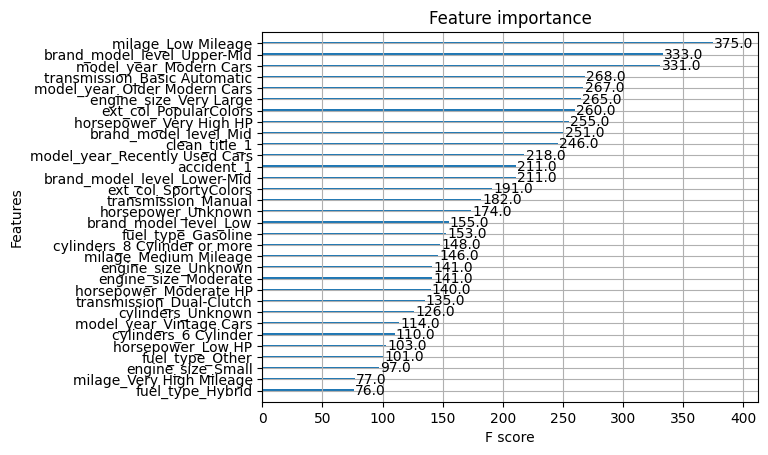

In [40]:
# ---------------- XGBoost Regressor ----------------

# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
# Fit the XGBoost model to the training data
xgb_regressor.fit(X_train_encoded_df, y_train)

# Predict and evaluate the model on test data
y_pred_xgb = xgb_regressor.predict(X_test_encoded_df)

# Calculate RMSE (Root Mean Squared Error)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

# Optional: Feature importance
xgb.plot_importance(xgb_regressor)

In [41]:
# ---------------- Random Forest Regressor ----------------
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf_regressor.fit(X_train_encoded_df, y_train)
y_pred_rf = rf_regressor.predict(X_test_encoded_df)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 69226.39895864375


In [42]:
# ---------------- CatBoost Regressor ----------------
catboost_regressor = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
catboost_regressor.fit(X_train_encoded_df, y_train)
y_pred_cat = catboost_regressor.predict(X_test_encoded_df)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print(f"CatBoost RMSE: {rmse_cat}")

CatBoost RMSE: 68748.97803807982


In [34]:
# ---------------- Support Vector Regressor (SVM) ----------------(very slow compare to other algorithms 26 minutes vs a few seconds with other algorithms)
svm_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_regressor.fit(X_train_encoded_df, y_train)
y_pred_svm = svm_regressor.predict(X_test_encoded_df)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print(f"SVM RMSE: {rmse_svm}")

SVM RMSE: 74412.8029436828


In [43]:
# Try catboost with original features

# Identify the indices of categorical features in the dataset
categorical_features = ["brand_model_level", "model_year", "milage", "fuel_type", "transmission", 
                        "ext_col", "int_col", "accident", "clean_title", "horsepower", "engine_size", "cylinders"]

# Step 2: Split the dataset into training and testing
X = train_df[features]
y = train_df[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Use CatBoost without One-Hot Encoding and specify categorical features
# Initialize the CatBoost Regressor
catboost_regressor = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Train the CatBoost model, passing the indices of the categorical features
catboost_regressor.fit(X_train, y_train, cat_features=categorical_features)

# Predict and evaluate the model on the test data
y_pred_cat = catboost_regressor.predict(X_test)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print(f"CatBoost RMSE without One-Hot Encoding: {rmse_cat}")

CatBoost RMSE without One-Hot Encoding: 68740.76152542296


## Hyperparameter Tuning

	•	Industry Standard: Select the best-performing models first, then perform hyperparameter tuning on these models.
	•	Why: Tuning is time-consuming, so focusing on the top models ensures efficiency.
	•	Tools: Use Grid Search, Random Search, or Bayesian Optimization for tuning after selecting the best models.

## Ensemble Methods

# Eveluate and Submit

### Holdout data simulation

In [125]:
# holdout_df = feature_engineering(holdout_df)
# holdout_df_final = holdout_df[['brand_model_level',
#  'model_year',
#  'milage',
#  'fuel_type',
#  'transmission',
#  'ext_col',
#  'int_col',
#  'accident',
#  'clean_title',
#  'horsepower',
#  'engine_size',
#  'cylinders',
#  'price']]

# # Step 1: Define features and target for training
# categorical_features = ["brand_model_level", "model_year", "milage", "fuel_type", "transmission", 
#             "ext_col", "int_col", "accident", "clean_title", "horsepower", "engine_size", "cylinders"]
# target = "price"

# # Step 2: Train the CatBoost model
# X_train_final = train_df_final[features]  # Use all rows from train_df_final
# y_train_final = train_df_final[target]

# # Initialize the CatBoost Regressor (you can tune hyperparameters if needed)
# catboost_regressor = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# # Train the CatBoost model
# catboost_regressor.fit(X_train_final, y_train_final, cat_features=categorical_features)

# # Step 3: Make predictions on test_df_final
# X_holdout_final = holdout_df_final[features]
# y_holdout_final = holdout_df_final[target]
# y_holdout_pred = catboost_regressor.predict(X_holdout_final)

# # Calculate RMSE (Root Mean Squared Error)
# rmse_catboost_holdout = np.sqrt(mean_squared_error(y_holdout_final, y_holdout_pred))
# print(f"XGBoost Holdout RMSE: {rmse_catboost_holdout}")

### Prepare Submittion

**Catboost**

Fisrst Try with RMSE: 73380.46685, Rank: 905

In [121]:
# Step 1: Define features and target for training
categorical_features = ["brand_model_level", "model_year", "milage", "fuel_type", "transmission", 
            "ext_col", "int_col", "accident", "clean_title", "horsepower", "engine_size", "cylinders"]
target = "price"

# Step 2: Train the CatBoost model
X_train_final = train_df_final[features]  # Use all rows from train_df_final
y_train_final = train_df_final[target]

# Initialize the CatBoost Regressor (you can tune hyperparameters if needed)
catboost_regressor = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Train the CatBoost model
catboost_regressor.fit(X_train_final, y_train_final, cat_features=categorical_features)

# Step 3: Make predictions on test_df_final
X_test_final = test_df_final[features]
y_test_pred = catboost_regressor.predict(X_test_final)

# Step 4: Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Retrieve the 'id' from test_df
    'price': y_test_pred  # Use the predicted prices
})

# Step 5: Save the submission file
submission_df.to_csv('/Users/shudizhao/data_projects/used_car_price_prediction/catboost_submission_v1.csv', index=False)

# Check the first few rows of the submission
print(submission_df.head())

       id         price
0  188533  17949.952982
1  188534  87647.873236
2  188535  62651.792135
3  188536  33468.854597
4  188537  30724.054135


**XGBoost**

Fisrst Try with RMSE: 73221.38042, Rank: 862

In [129]:
# Step 1: Define features and target for training
categorical_features = ["brand_model_level", "model_year", "milage", "fuel_type", "transmission", 
            "ext_col", "int_col", "accident", "clean_title", "horsepower", "engine_size", "cylinders"]
target = "price"

# Step 2: Prepare the data (One-Hot Encoding for XGBoost since it doesn't handle categorical features natively)
X_train_final = train_df_final[categorical_features]
y_train_final = train_df_final[target]

# Apply One-Hot Encoding to categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit the encoder and transform the training data
X_train_encoded = encoder.fit_transform(X_train_final)

# Step 3: Train the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

# Train the XGBoost model
xgb_regressor.fit(X_train_encoded, y_train_final)

# Step 4: Prepare the test data for predictions
X_test_final = test_df_final[categorical_features]

# Transform the test data using the same encoder
X_test_encoded = encoder.transform(X_test_final)

# Step 5: Make predictions on the test set
y_test_pred_xgb = xgb_regressor.predict(X_test_encoded)

# Step 6: Prepare the submission DataFrame
submission_df_xgb = pd.DataFrame({
    'id': test_df['id'],  # Retrieve the 'id' from test_df
    'price': y_test_pred_xgb  # Use the predicted prices
})

# Step 7: Save the submission file
submission_df_xgb.to_csv('/Users/shudizhao/data_projects/used_car_price_prediction/xgboost_submission_v1.csv', index=False)

# Check the first few rows of the submission
print(submission_df_xgb.head())

       id         price
0  188533  18737.607422
1  188534  85057.960938
2  188535  68017.976562
3  188536  35236.636719
4  188537  29576.582031
